In [328]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import scipy.linalg as la

from scipy.linalg import expm
from qiskit.quantum_info import Statevector, partial_trace, Operator, DensityMatrix
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector

np.set_printoptions(precision=5)


def get_H0(N):
    """The uniform matrix"""
    v = get_v0(N)
    return np.dot(v, v.T.conj())

def get_H0_r(N):
    m = np.matrix([[1/N, np.sqrt(N-1)/N],
                  [np.sqrt(N-1)/N, (N-1)/N]], dtype=complex)
    return m

def get_v0(N):
    v = np.ones((N,1))*(1/np.sqrt(N))
    return np.matrix(v)
    
def get_vp(N):
    pv = np.zeros((N,1))
    pv[N-1] = 1
    return np.matrix(pv)
    
def get_Hp(N):
    pv = get_vp(N)
    return np.dot(pv, pv.T.conj())

def get_Hp_r():
    m = np.matrix([[1, 0],
                  [0, 0]])
    return m

def get_H_op(delt, n, H):
    """
    Input:
        delt: time interval
        n: number of qubits
        H: Hamiltonian matrix
    return Operator exp(-itH)
    """
    H = H*(-1j*delt)
    exp_H = expm(H)
    h = QuantumCircuit(n, name = 'H_op')
    h.unitary(exp_H, range(n))
    return h.to_gate()

def get_f(t, epsilon, N):
    """
    Time evolve function
    Input:
        t: time point
        epsilon: error value
        N: 2**n
    return value from 0 to 1
    """
    arg = ((2*epsilon*np.sqrt(N-1)*t)/N - np.arctan(np.sqrt(N-1)))
    num = np.tan(arg) / np.sqrt(N-1)
    den = 1 + num
    result = 0.5 * den
    return result

def get_fp(t, epsilon, N, R):
    T = get_adiabatic_T(epsilon, N)
    delt = T/R
    fps = []
    tp = delt
    for _ in range(R):
        fp = get_f(tp, epsilon, N)
        fps.append(get_f(tp, epsilon, N))
        tp += delt
    index = (int)(t/delt)
    return fps[index]

def get_adiabatic_T(epsilon, N):
    t1 = 1/epsilon
    t2 = N/np.sqrt(N-1)
    t3 = np.arctan((np.sqrt(N-1)))
    return t1*t2*t3

def get_simulation_T(a):
    return np.pi/(2*a)

def get_R(epsilon, N):
    """get the total iteration R"""
    return (int)(np.sqrt(N)/(epsilon**3))

def get_state(qc):
    m = DensityMatrix(qc)
    v = m.to_statevector().data
    return np.matrix(v).T
    
def get_Epsilon1(v1, v2):
    """return from 0 to 1"""
    res = np.dot(v1.T.conj(), v2)
    return (1-abs(res)**2)

def get_Epsilon2(final_vector, marked_vector):
    """
    get the epsilon of the result, should lower than the theoretical epsilon

    """
    distance_vector = final_vector - marked_vector
    values = np.dot(distance_vector.conj().T,distance_vector)
    return np.sqrt(values)

def get_e1(circ):
    return get_Epsilon1(get_state(circ), get_vp(N)).item(0)

def get_Epsilon2by1(e1):
    return np.sqrt(2-2*np.sqrt(1-e1))

def get_eH(t, H):
    m = H*(-1j*t)
    exp_H = expm(m)
    return exp_H

def get_norm(v):
    return np.sqrt(np.matmul(v.T.conj(), v))

def normalize_vector(v):
    n = get_norm(v)
    v = v/n
    return v

def adiabatic_search_circuit(n, epsilon, T, R):
    circ = QuantumCircuit(n)
    circ.h(range(n))
    for r in range(0, R):
        t = r*(T/R)
        H0 = np.identity(N) - get_H0(N)
        Hp = np.identity(N) - get_Hp(N)
        H = (1-get_f(t,epsilon,N))*H0 + get_f(t,epsilon,N)*Hp
        circ.append(get_H_op(T/R,n,H), range(n))
    return get_state(circ)

In [345]:
n = 2
N = 2**n
epsilon = 0.3
vp = get_vp(N)

rs = []
fs = []
es = []

T = get_adiabatic_T(epsilon, N)
R = get_R(epsilon, N)
Rp = R**2

c1 = adiabatic_search_circuit(n, epsilon, T, R)
c2 = adiabatic_search_circuit(n, epsilon, T, Rp)

# plt.plot(rs, es)
print("R:" + str(get_R(epsilon, N)))
print("T:" + str(T))
# print(c1)
print("psi, psip: " + str(get_Epsilon1(c1, c2)))
print("e1: psi, m: " + str(get_Epsilon1(c1, vp)))
print("e1: psip, m: " + str(get_Epsilon1(c2, vp)))
print("e2: psi, m: " + str(get_Epsilon2(c1, vp)))
print("e2: psip, m: " + str(get_Epsilon2(c2, vp)))
print("bound 1: " + str(epsilon**2))
print("bound 2: " + str(epsilon))
print("bound: " + str(2*(T/R)))

R:74
T:8.061330507707638
psi, psip: [[0.00018]]
e1: psi, m: [[0.06937]]
e1: psip, m: [[0.06931]]
e2: psi, m: [[0.26574+0.j]]
e2: psip, m: [[0.26563+0.j]]
bound 1: 0.09
bound 2: 0.3
bound: 0.21787379750561184


Text(0.5, 0, 't')

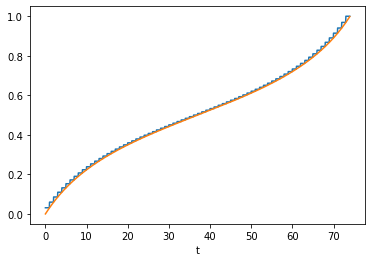

In [202]:
n = 2
N = 2**n
epsilon = 0.3
T = get_adiabatic_T(epsilon, N)
R = get_R(epsilon, N)
delt = T/R

rs = []
fs = []
fps = []

tn = 20
for r in range(0, tn*R):
    r = r/tn
    t = r*(T/R)
    rs.append(r)
    fs.append(get_f(t,epsilon,N))
    fps.append(get_fp(t,epsilon,N,R))

plt.plot(rs, fps)
plt.plot(rs, fs)
plt.xlabel("t")